In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'EUR=X'
numbers_in_currency = 'EUR'
share_name = 'BAYN.DE'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-03-31,10352,-4734,5618,1398,2631,9444,7391,22085,10575,...,4155,0,4139,15285,8102,35452,163,-357,826.95,2014-05-10
1,2014-06-30,10228,-4991,5237,919,1228,9423,7416,20990,10322,...,4136,0,3589,14670,8008,35490,1601,-529,826.95,2014-08-09
2,2014-09-30,9967,-4859,5108,808,1680,9099,7928,25359,10608,...,4505,0,3107,14759,11402,40426,1816,-546,826.95,2014-11-09
3,2014-12-31,10792,-5325,5467,218,1853,9097,8478,22227,15347,...,5363,0,3376,15503,18484,50128,2230,-939,826.95,2015-03-01
4,2015-03-31,11793,-5436,6357,1282,1607,11466,8776,24951,16405,...,5211,0,6512,20263,16921,54905,727,-345,826.95,2015-05-10


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2023-03-31,2023-05-10,982.42,14389,-5733,8656,2182,4854,14559,13531,...,23352,125052,6268,0,9728,34391,33571,84188,-3550,-466
37,2023-06-30,2023-08-09,982.42,11044,-4718,6326,-1889,4481,13717,13768,...,23438,121667,5970,0,9960,32187,36557,84719,483,-606
38,2023-09-30,2023-11-09,982.42,10342,-4812,5530,-4577,6815,10532,13956,...,23169,117242,6500,0,12313,33081,35111,83862,2576,-683
39,2023-12-31,2024-02-29,982.42,11862,-4486,7376,1342,5907,9343,13947,...,23363,116259,7456,0,6830,29457,38176,83332,5608,-996
40,2024-03-31,2024-05-13,982.42,13765,-5463,8302,2002,4725,14194,13437,...,23343,119881,6398,0,8281,30630,37987,84119,-2150,-446


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-03-31,2023-05-10,982.42,14389,-5733,8656,2182,4854,14559,13531,...,125052,6268,0,9728,34391,33571,84188,-3550,-466,0.932003
37,2023-06-30,2023-08-09,982.42,11044,-4718,6326,-1889,4481,13717,13768,...,121667,5970,0,9960,32187,36557,84719,483,-606,0.918362
38,2023-09-30,2023-11-09,982.42,10342,-4812,5530,-4577,6815,10532,13956,...,117242,6500,0,12313,33081,35111,83862,2576,-683,0.918837
39,2023-12-31,2024-02-29,982.42,11862,-4486,7376,1342,5907,9343,13947,...,116259,7456,0,6830,29457,38176,83332,5608,-996,0.929674
40,2024-03-31,2024-05-13,982.42,13765,-5463,8302,2002,4725,14194,13437,...,119881,6398,0,8281,30630,37987,84119,-2150,-446,0.920544


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-03-31,2023-05-10,982.42,14389,-5733,8656,2182,4854,14559,13531,...,125052,6268,0,9728,34391,33571,84188,-3550,-466,0.932003
37,2023-06-30,2023-08-09,982.42,11044,-4718,6326,-1889,4481,13717,13768,...,121667,5970,0,9960,32187,36557,84719,483,-606,0.918362
38,2023-09-30,2023-11-09,982.42,10342,-4812,5530,-4577,6815,10532,13956,...,117242,6500,0,12313,33081,35111,83862,2576,-683,0.918837
39,2023-12-31,2024-02-29,982.42,11862,-4486,7376,1342,5907,9343,13947,...,116259,7456,0,6830,29457,38176,83332,5608,-996,0.929674
40,2024-03-31,2024-05-13,982.42,13765,-5463,8302,2002,4725,14194,13437,...,119881,6398,0,8281,30630,37987,84119,-2150,-446,0.920544


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-05-12,75.435104,2014-03-31,10352.0,0.0,25.400568,826.95,0.0,0.0,2631.0,...,0.372053,0.627947,0.0,0.0,0.0,0.0,0.542697,0.135046,0.0,0.0
1,2014-05-19,75.289330,2014-03-31,10352.0,0.0,25.400568,826.95,0.0,0.0,2631.0,...,0.372053,0.627947,0.0,0.0,0.0,0.0,0.542697,0.135046,0.0,0.0
2,2014-05-26,77.330086,2014-03-31,10352.0,0.0,25.400568,826.95,0.0,0.0,2631.0,...,0.372053,0.627947,0.0,0.0,0.0,0.0,0.542697,0.135046,0.0,0.0
3,2014-06-02,76.674133,2014-03-31,10352.0,0.0,25.400568,826.95,0.0,0.0,2631.0,...,0.372053,0.627947,0.0,0.0,0.0,0.0,0.542697,0.135046,0.0,0.0
4,2014-06-09,75.507988,2014-03-31,10352.0,0.0,25.400568,826.95,0.0,0.0,2631.0,...,0.372053,0.627947,0.0,0.0,0.0,0.0,0.542697,0.135046,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-05-12,75.435104,2014-03-31,10352.0,0.0,25.400568,826.95,0.0,0.0,2631.0,...,0.0,0.542697,0.135046,0.0,0.0,inf,2.969820,1.506498,2.299122,inf
1,2014-05-19,75.289330,2014-03-31,10352.0,0.0,25.400568,826.95,0.0,0.0,2631.0,...,0.0,0.542697,0.135046,0.0,0.0,inf,2.964081,1.503587,2.296211,inf
2,2014-05-26,77.330086,2014-03-31,10352.0,0.0,25.400568,826.95,0.0,0.0,2631.0,...,0.0,0.542697,0.135046,0.0,0.0,inf,3.044423,1.544342,2.336967,inf
3,2014-06-02,76.674133,2014-03-31,10352.0,0.0,25.400568,826.95,0.0,0.0,2631.0,...,0.0,0.542697,0.135046,0.0,0.0,inf,3.018599,1.531242,2.323867,inf
4,2014-06-09,75.507988,2014-03-31,10352.0,0.0,25.400568,826.95,0.0,0.0,2631.0,...,0.0,0.542697,0.135046,0.0,0.0,inf,2.972689,1.507953,2.300578,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

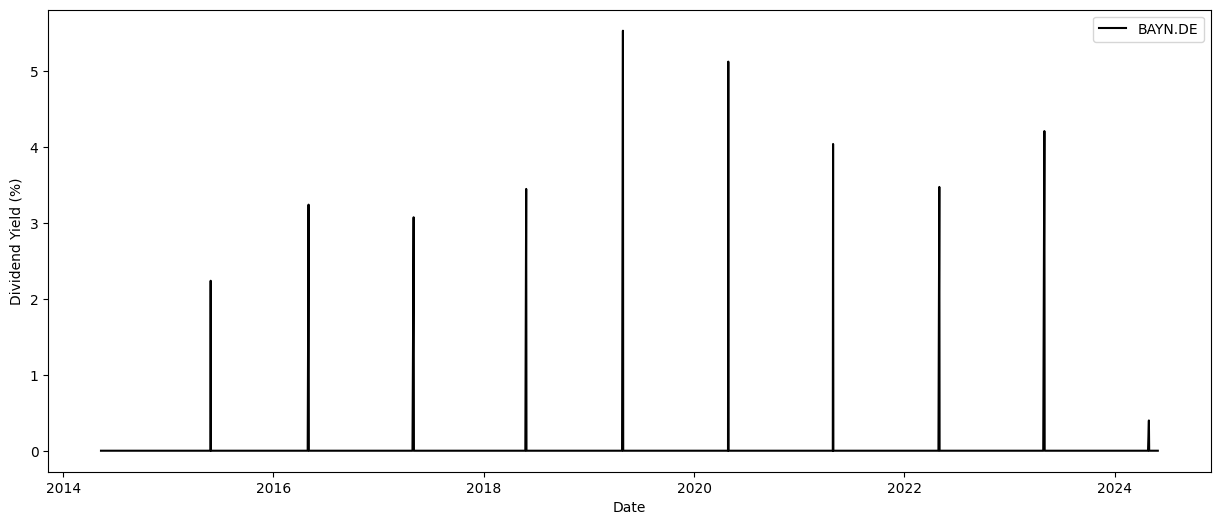

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   -0.190487
share_price      1.000000
Name: share_price, dtype: float64


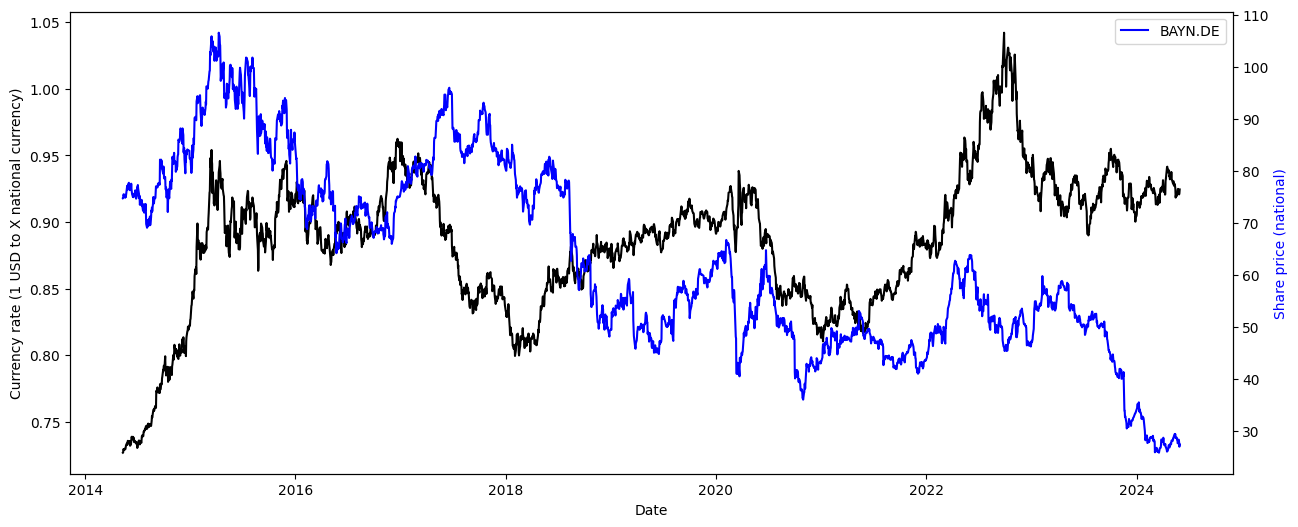

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

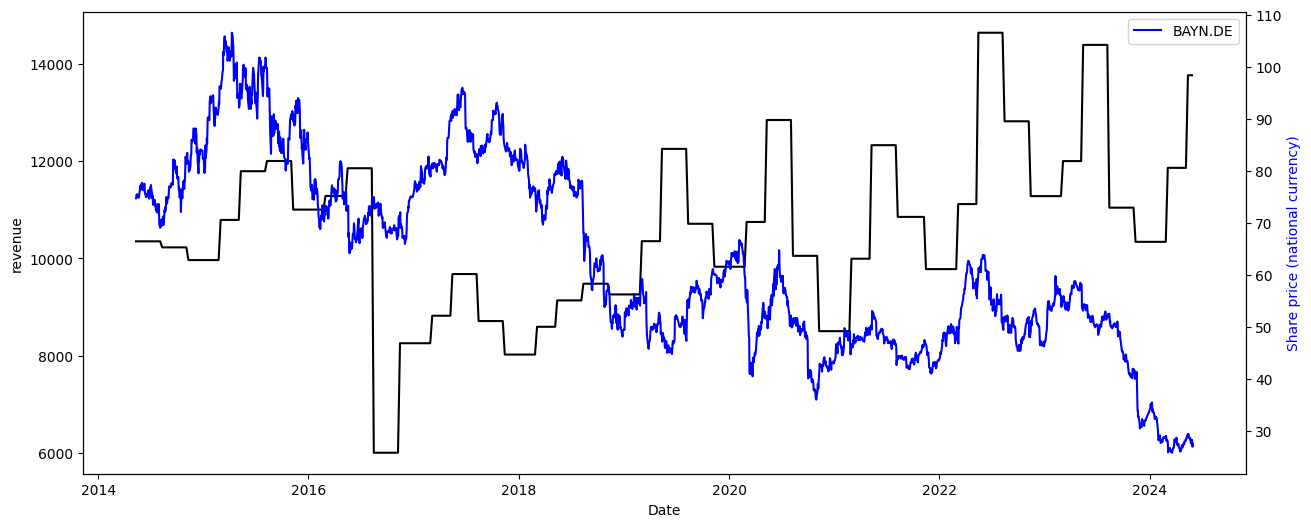

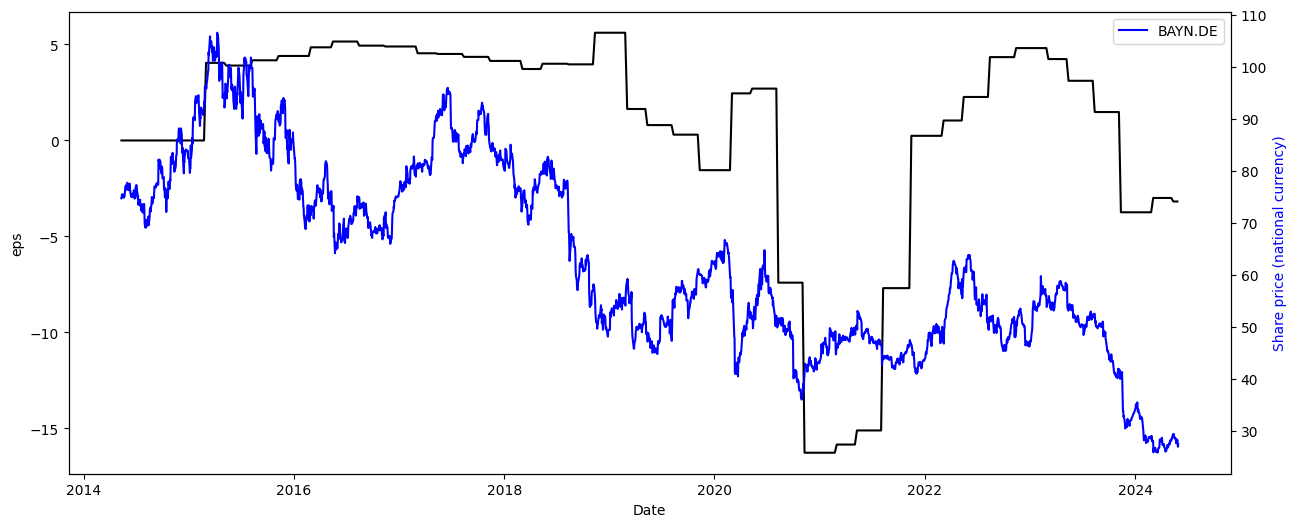

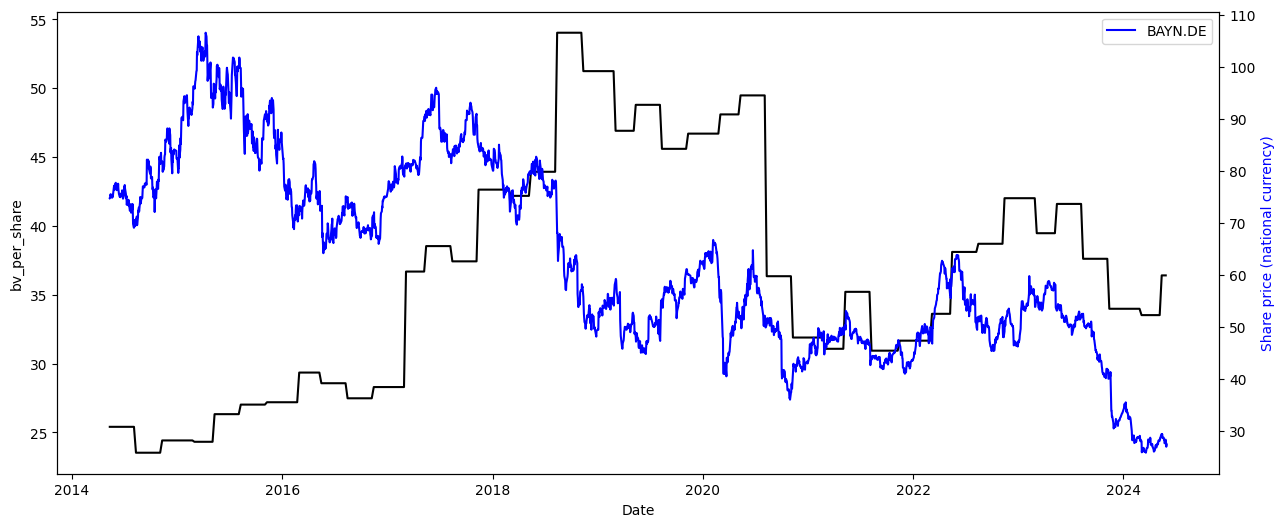

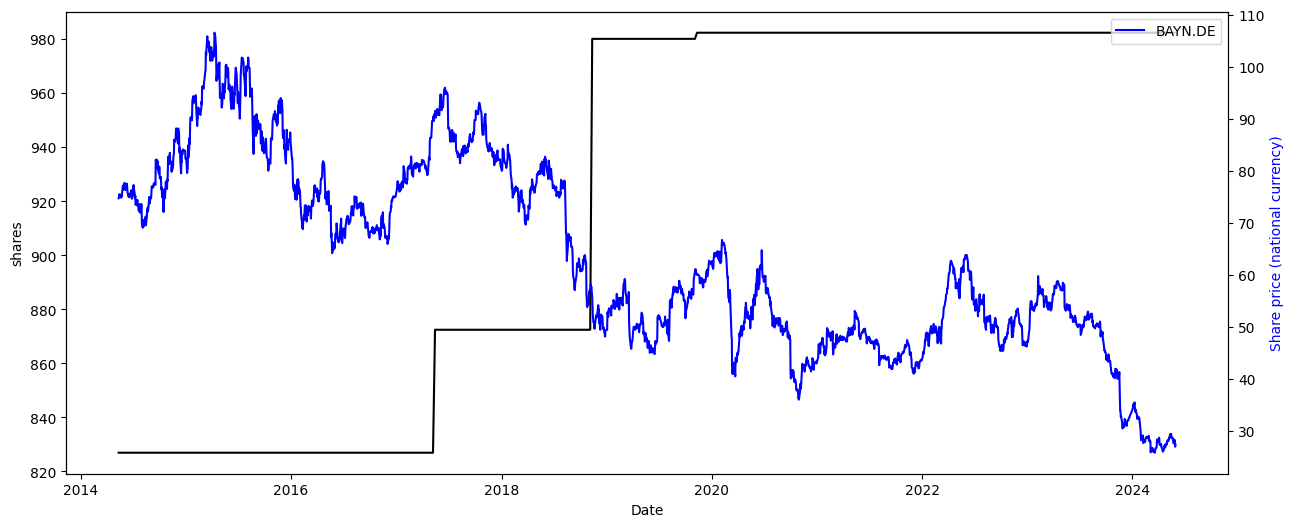

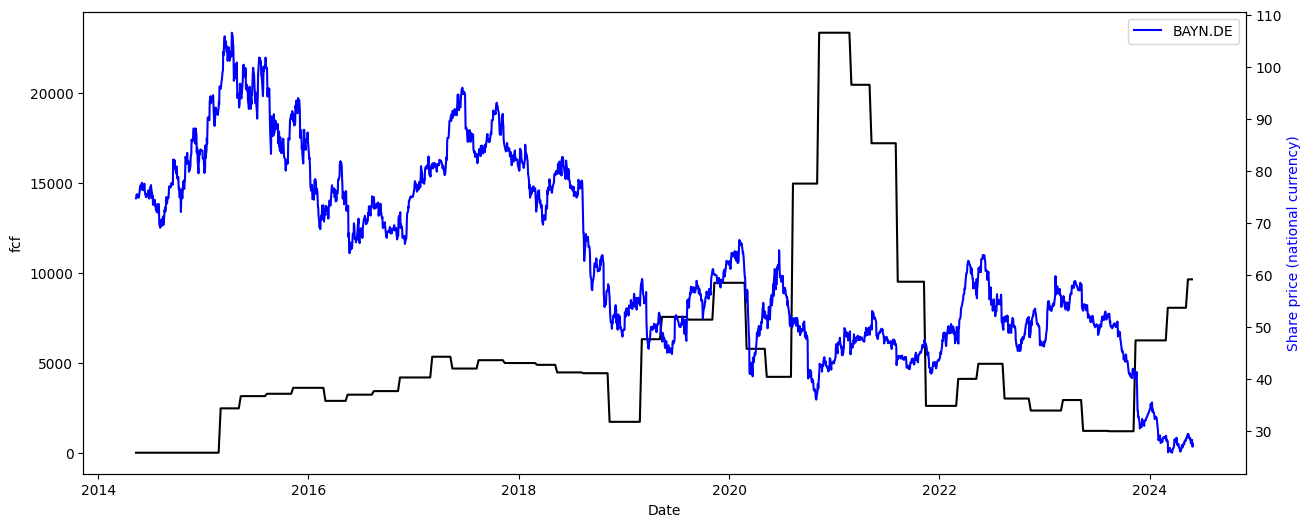

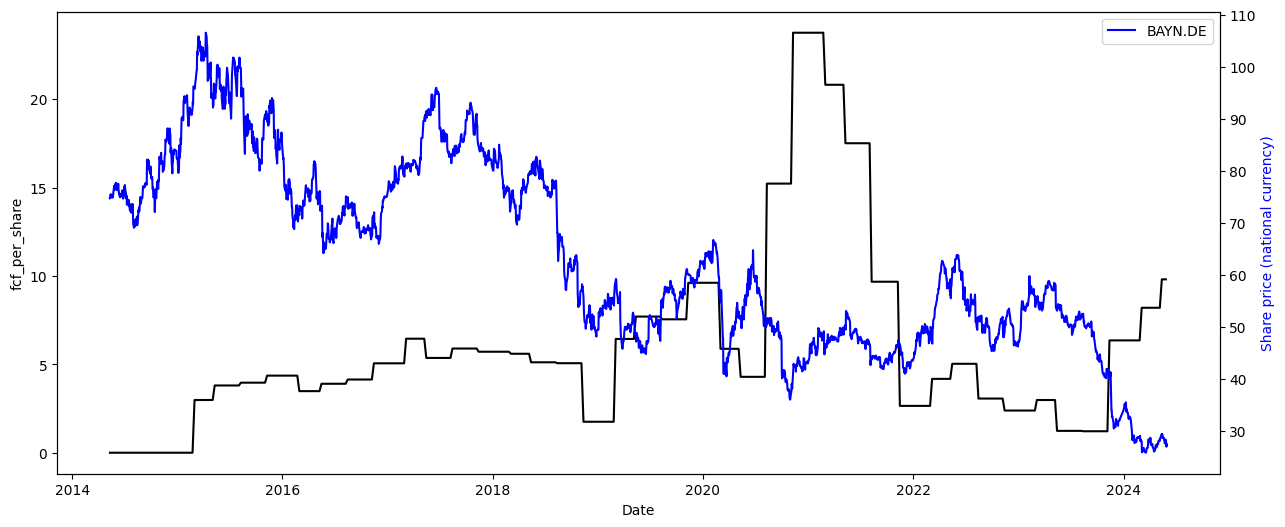

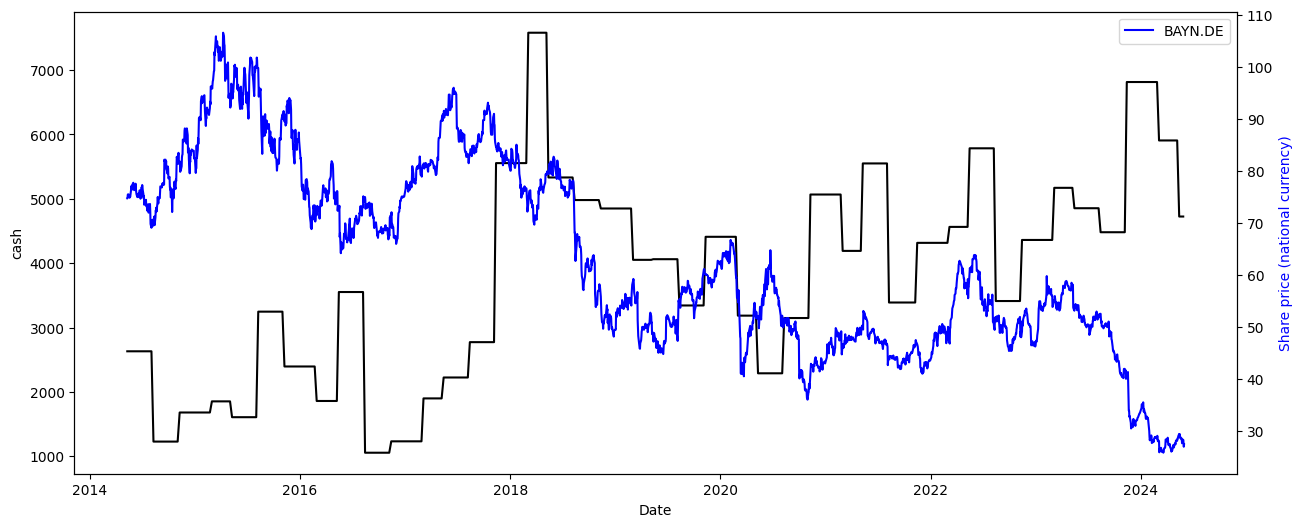

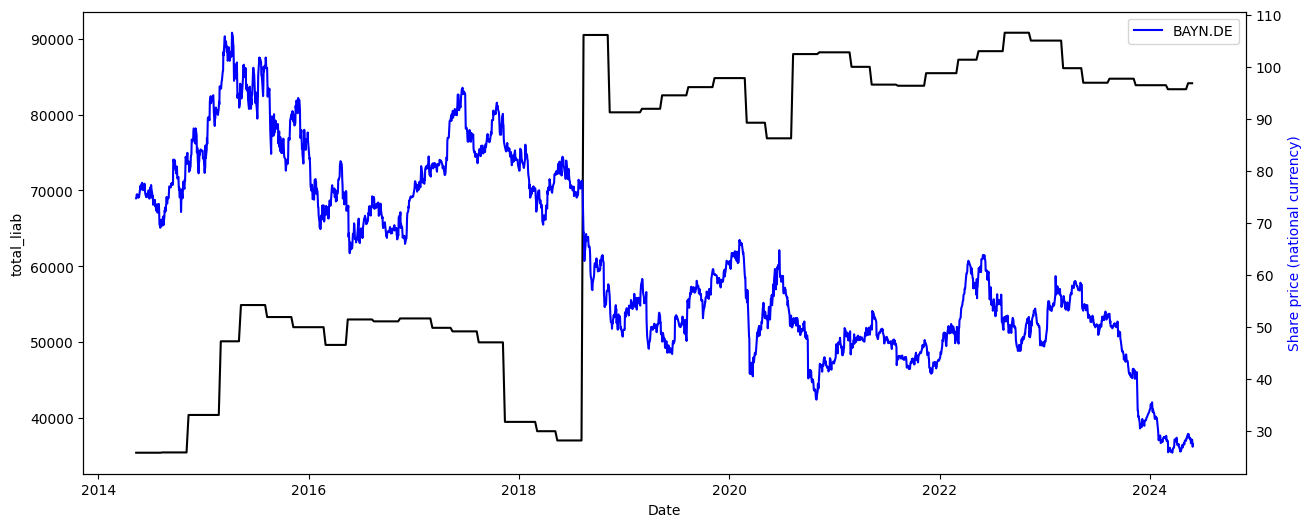

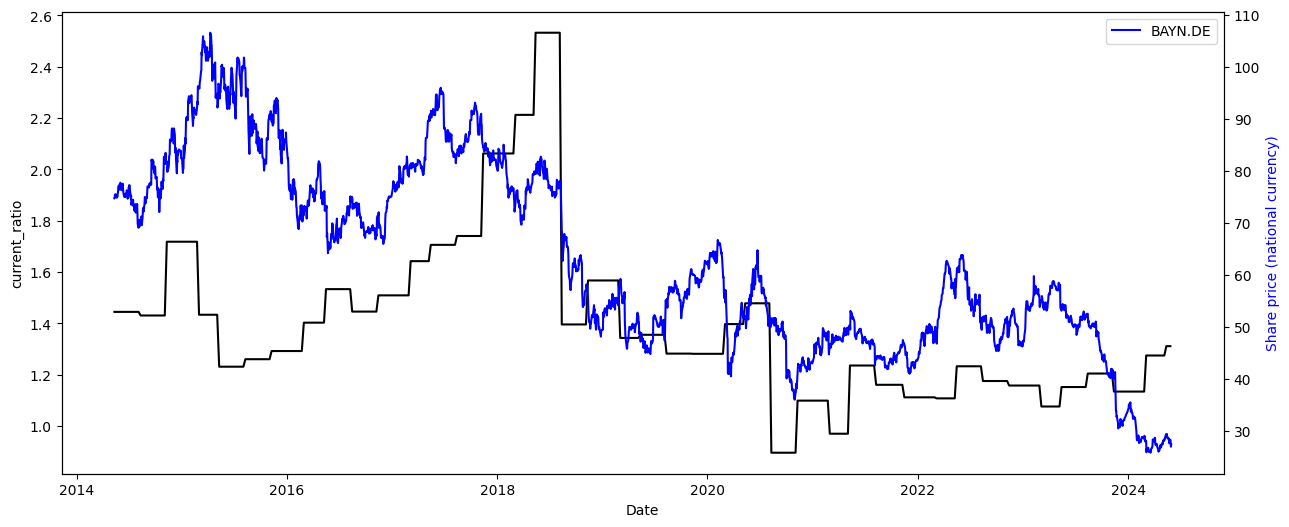

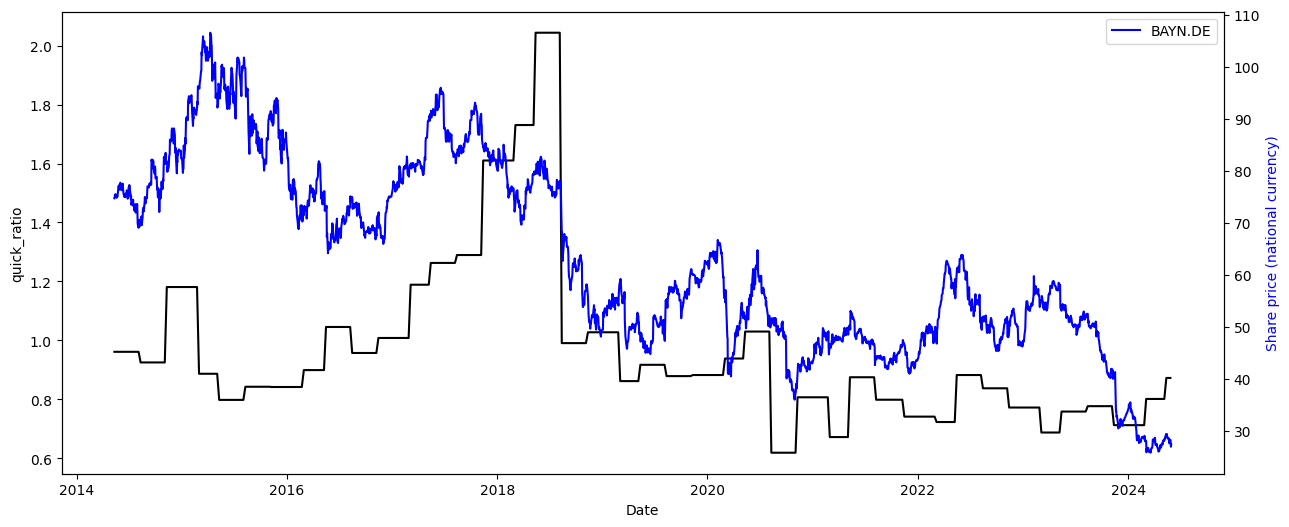

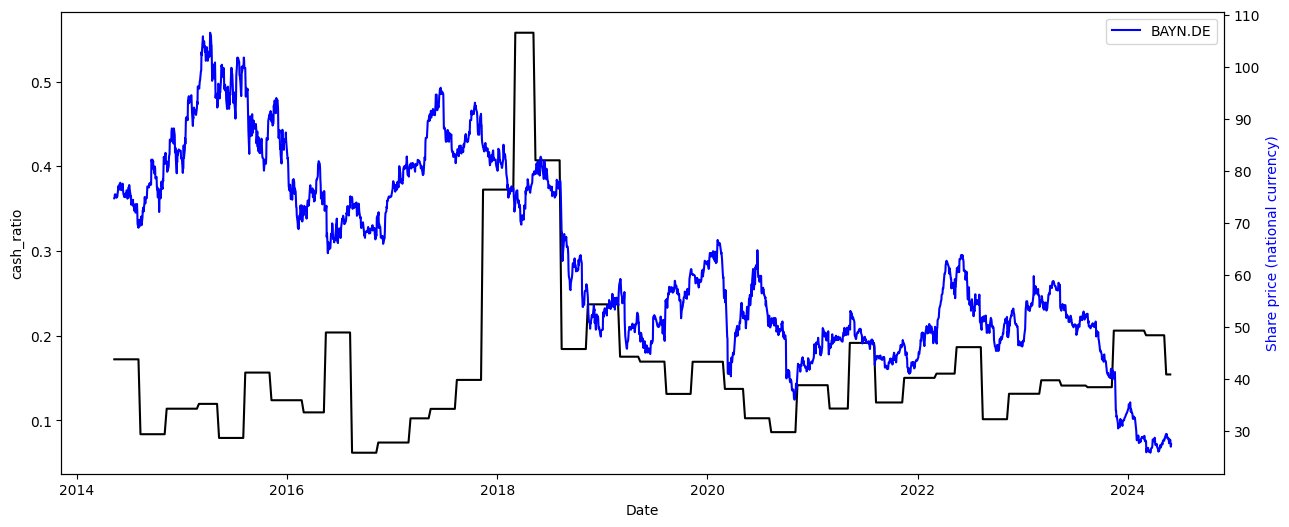

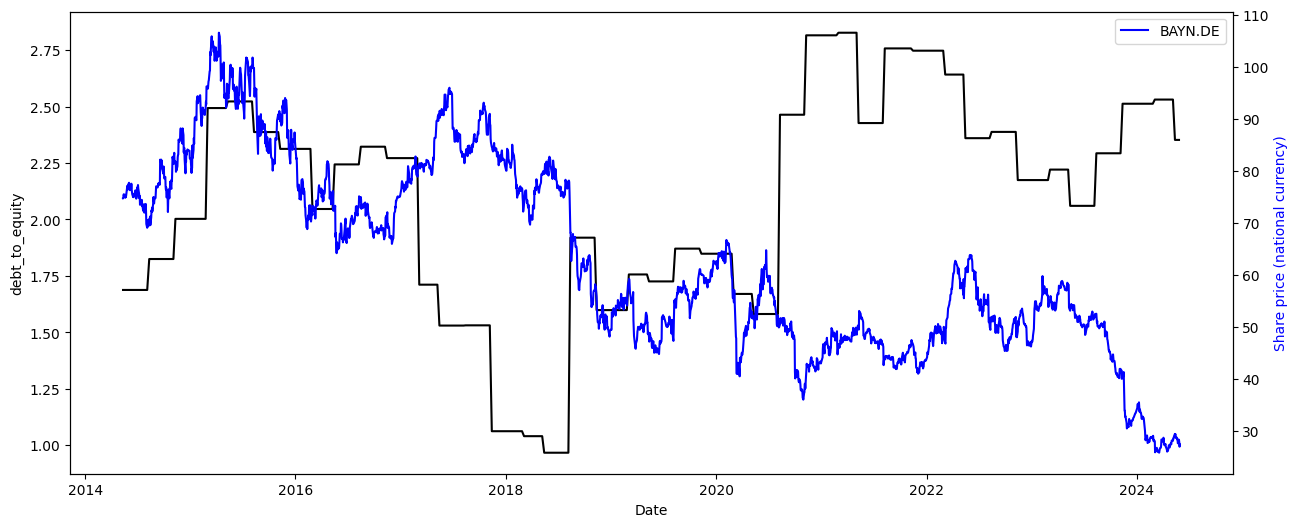

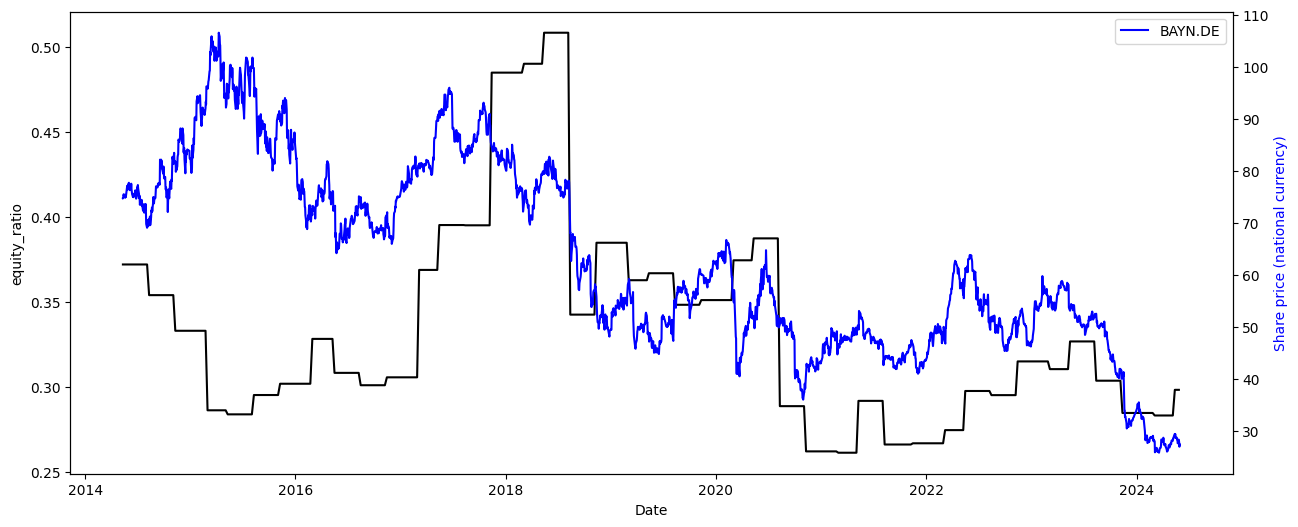

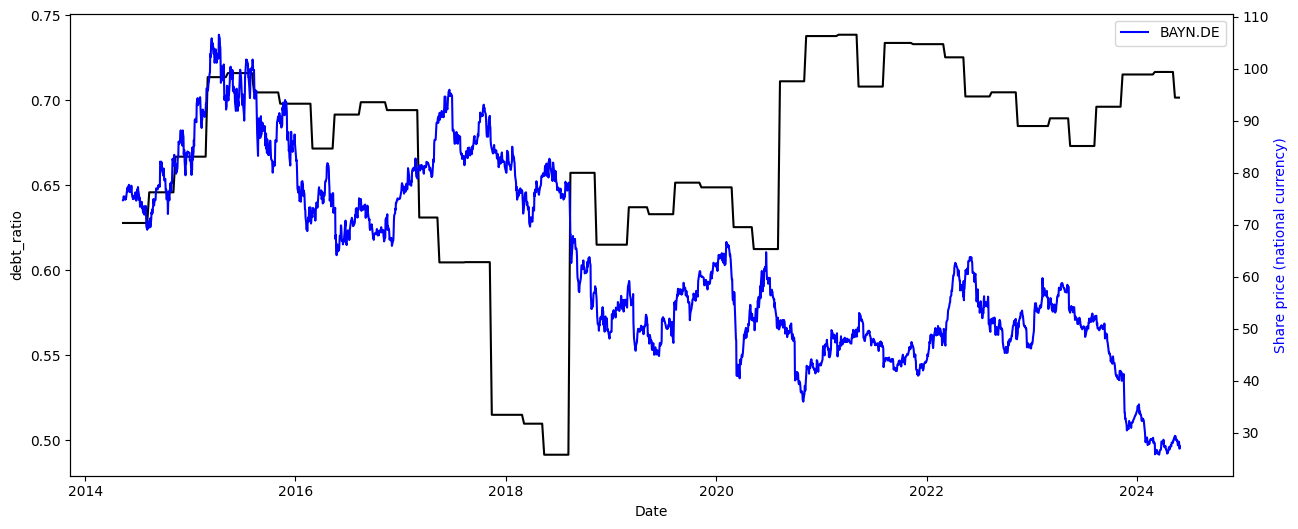

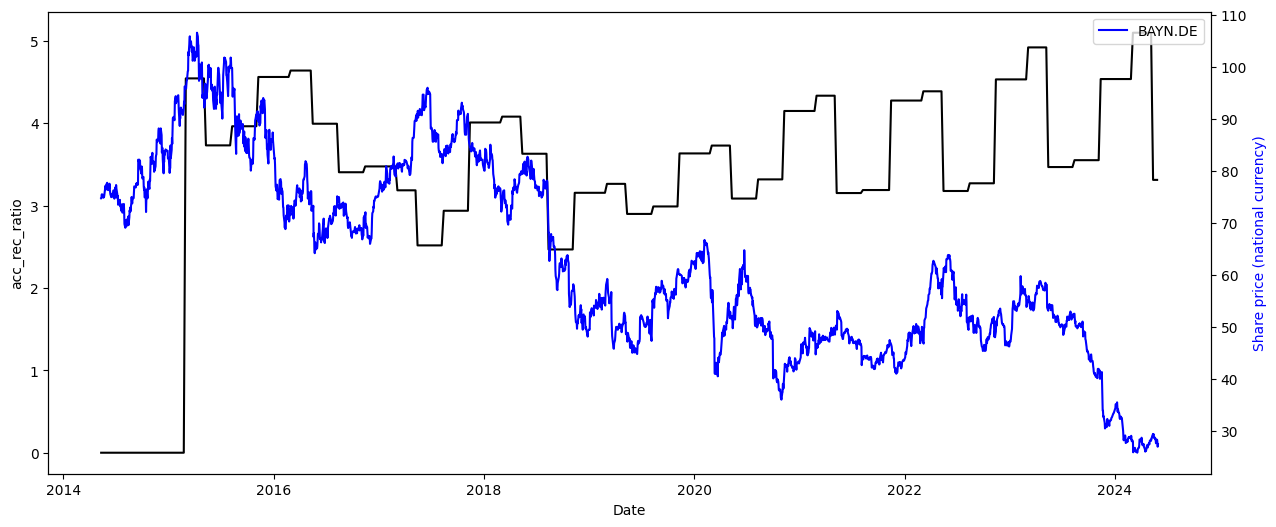

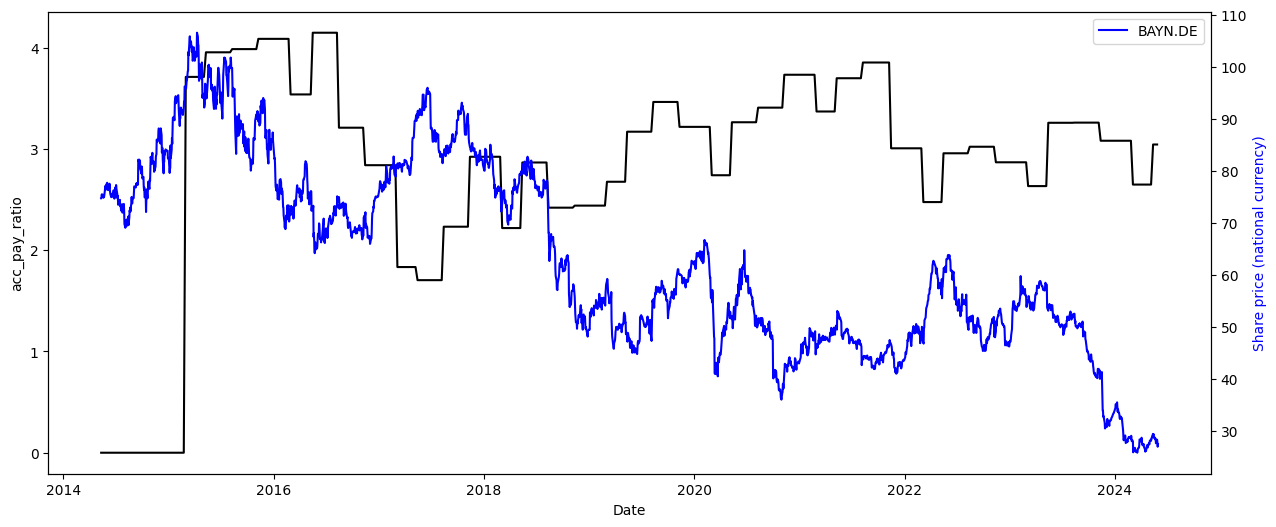

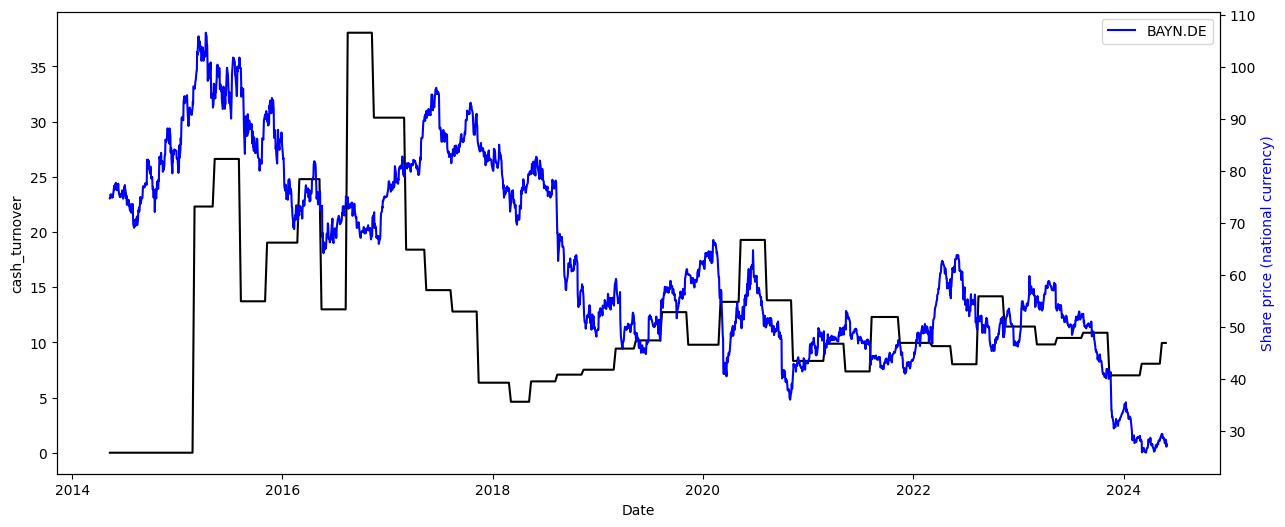

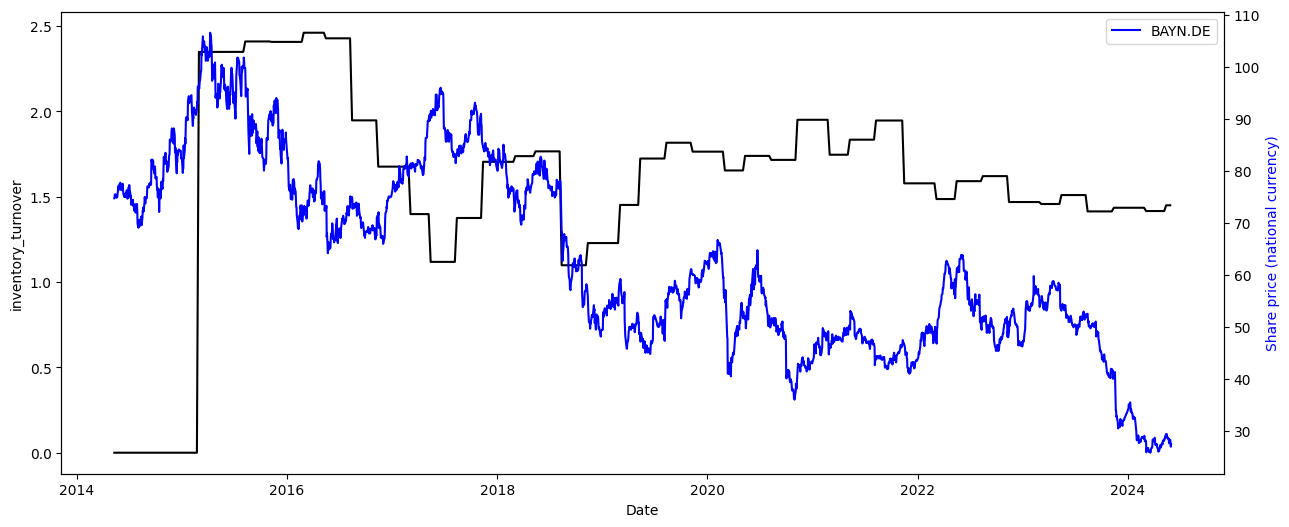

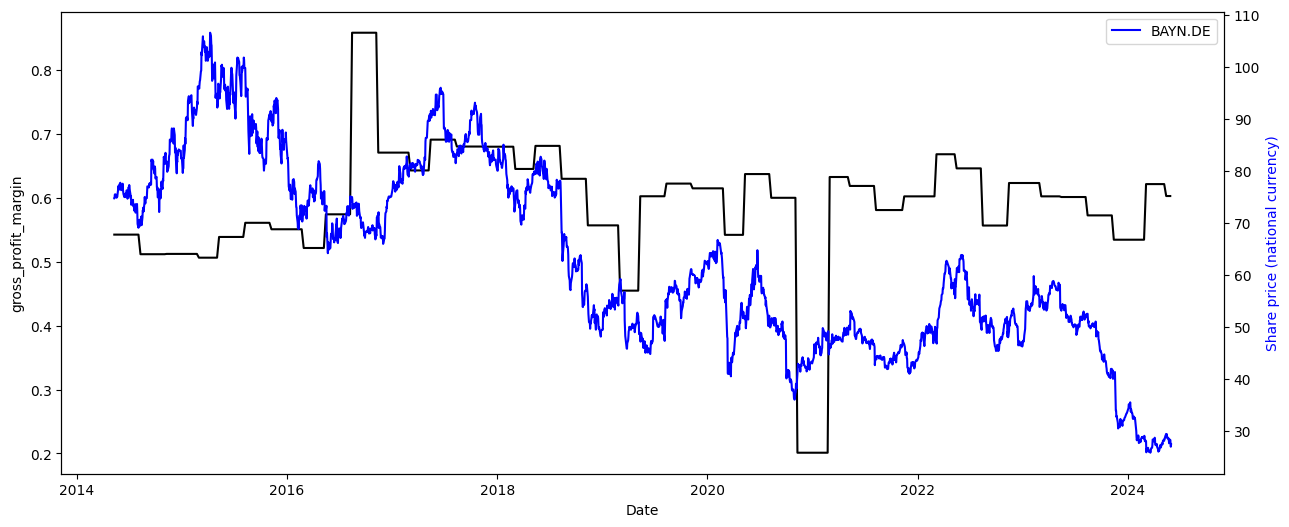

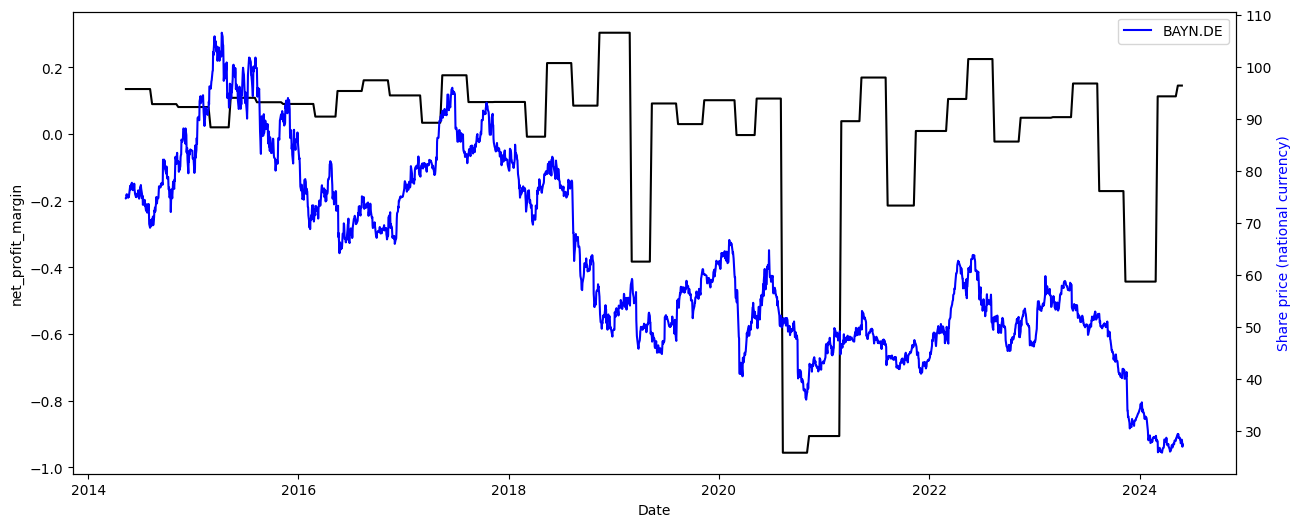

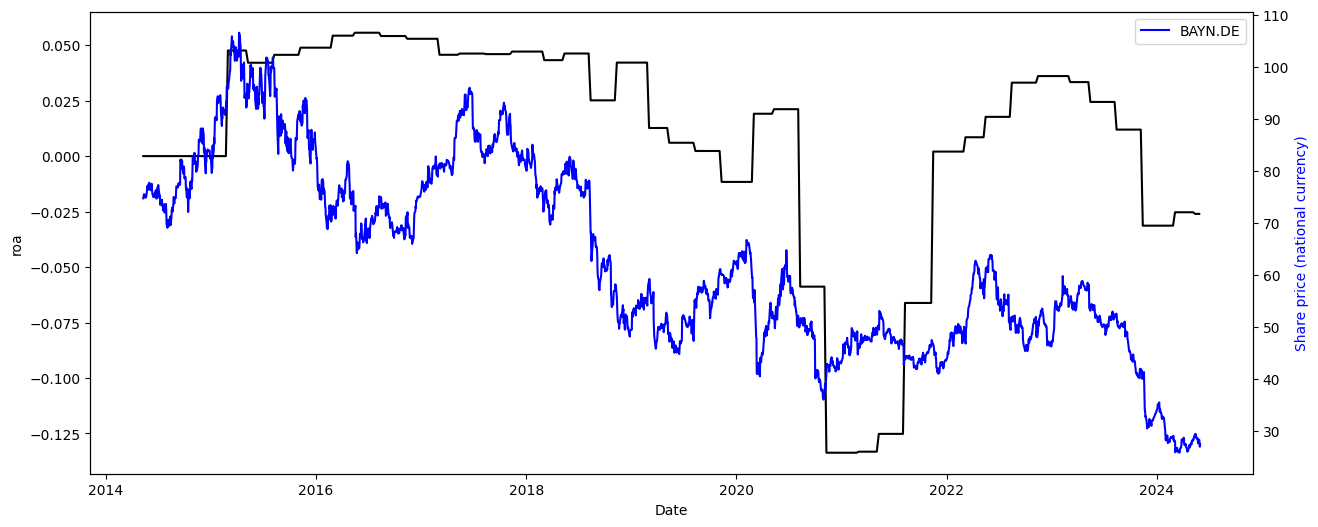

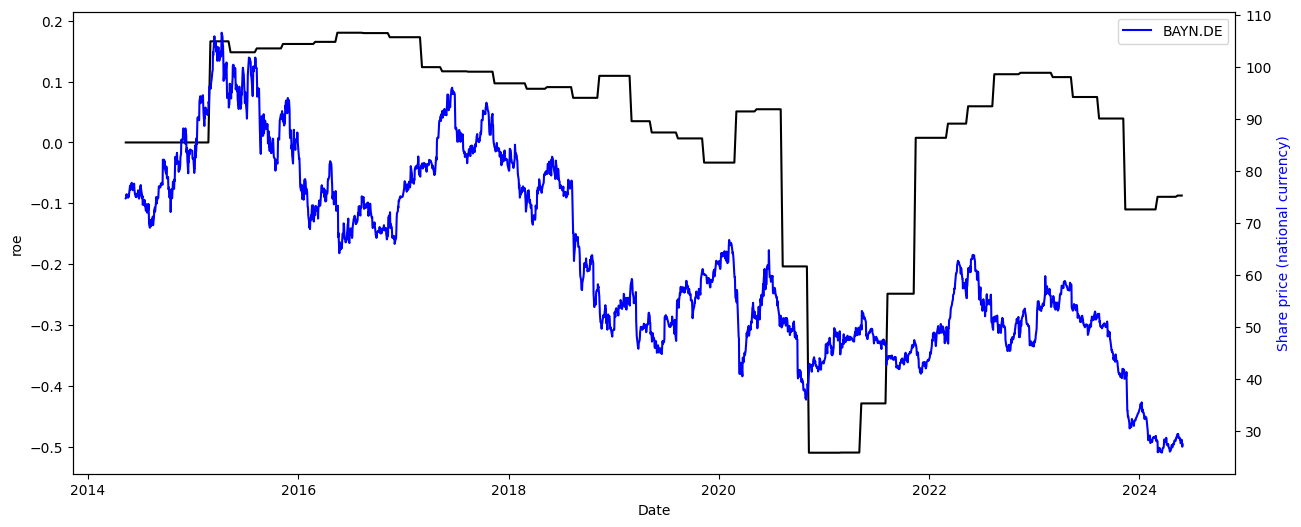

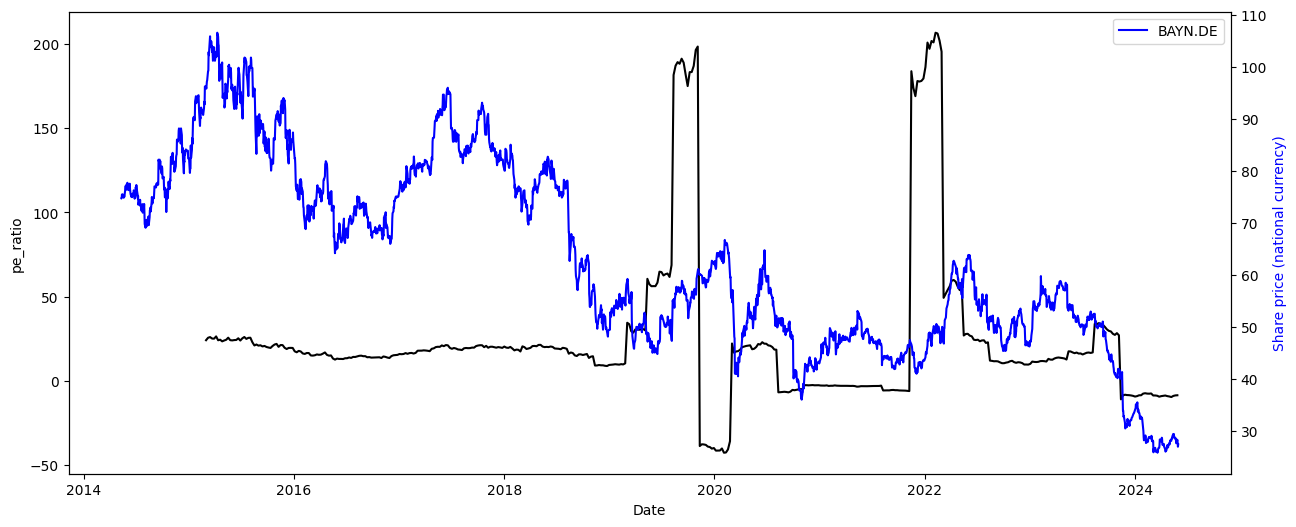

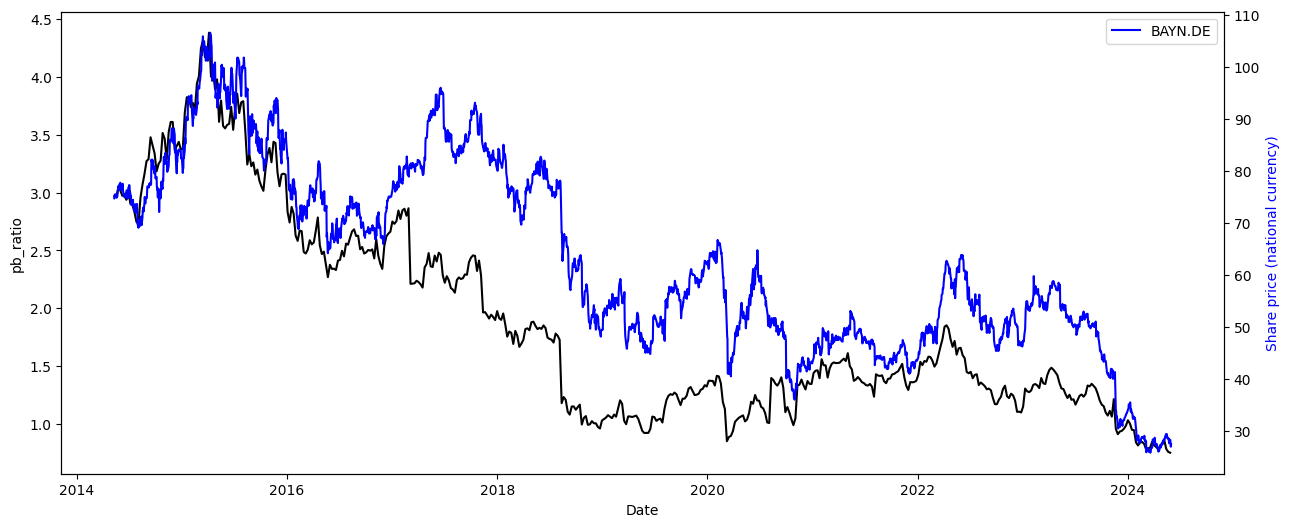

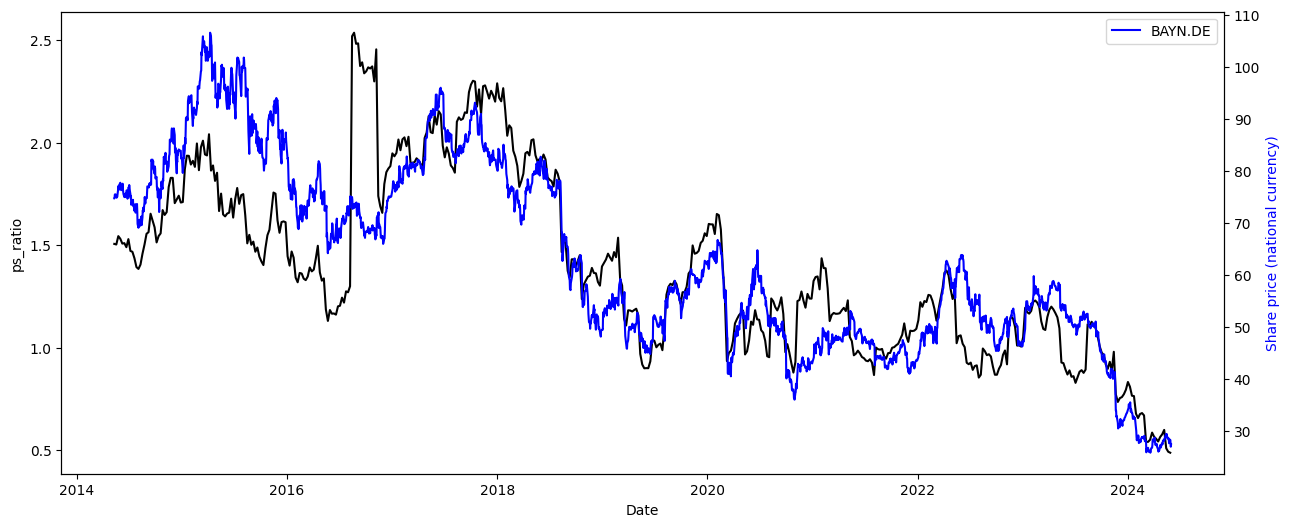

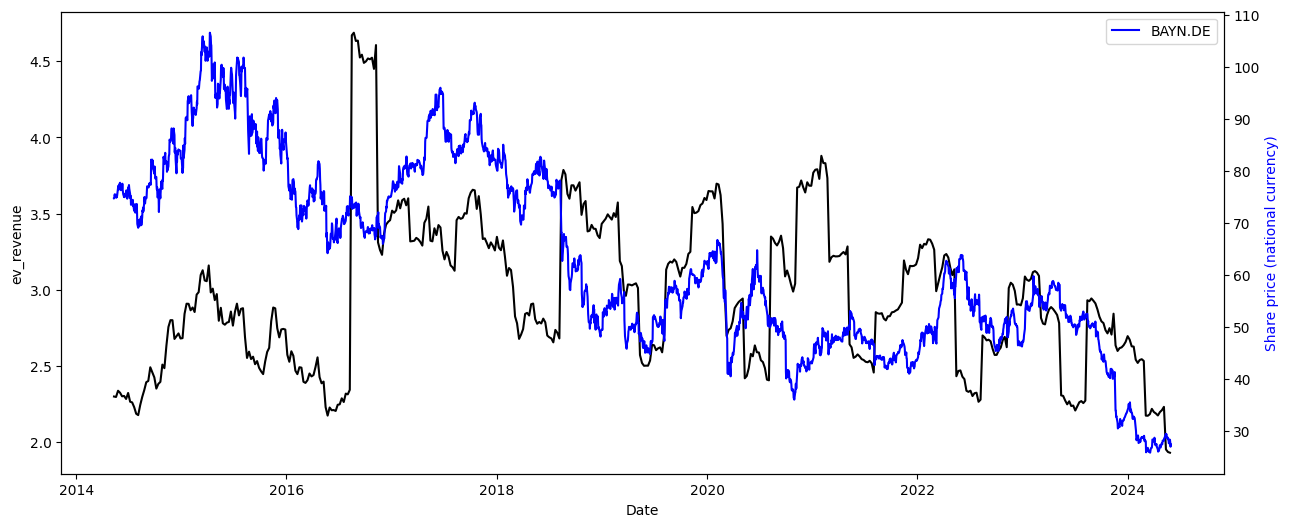

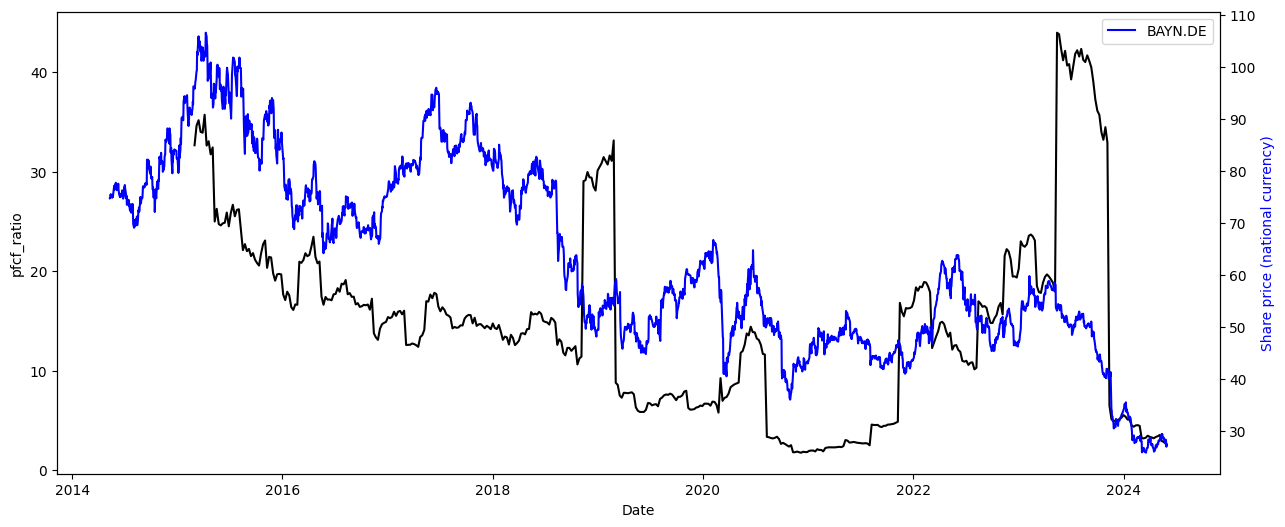

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

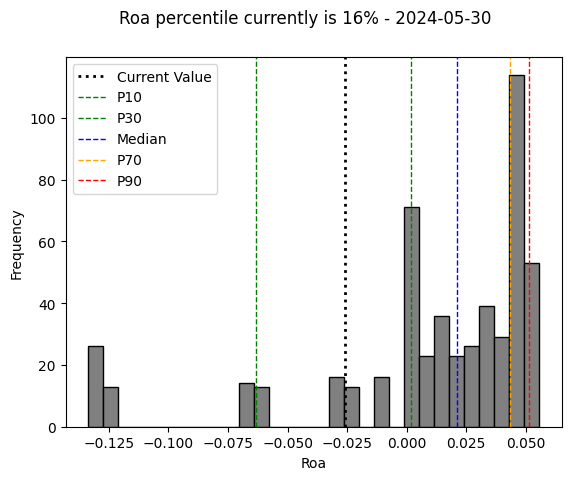

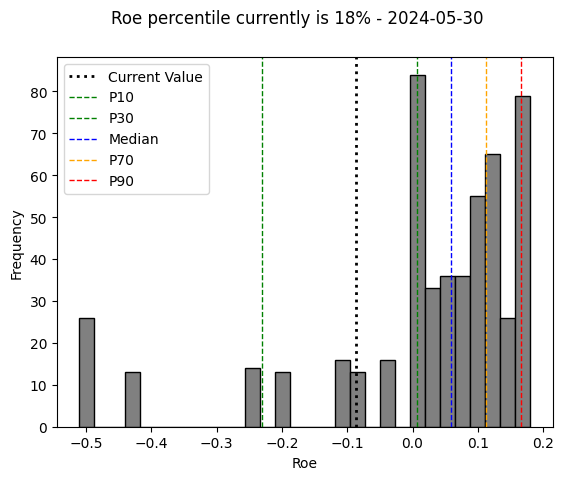

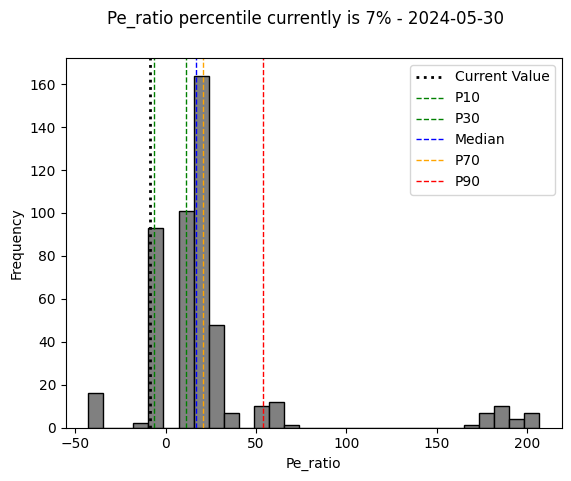

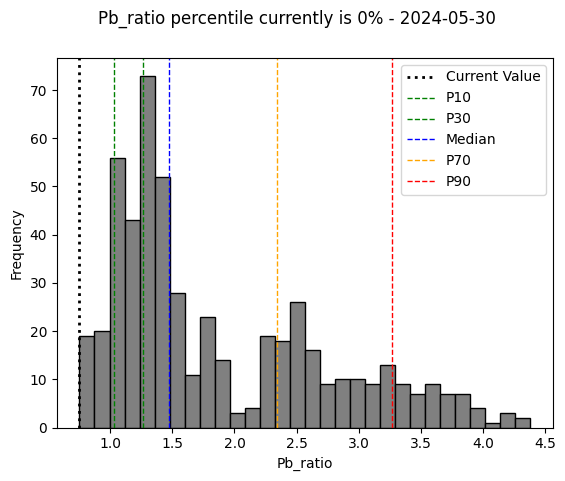

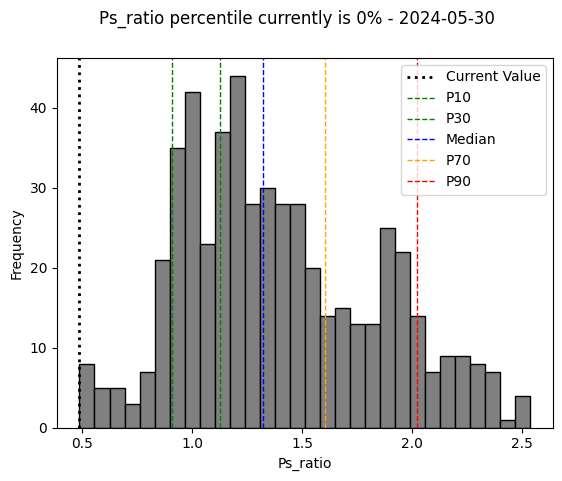

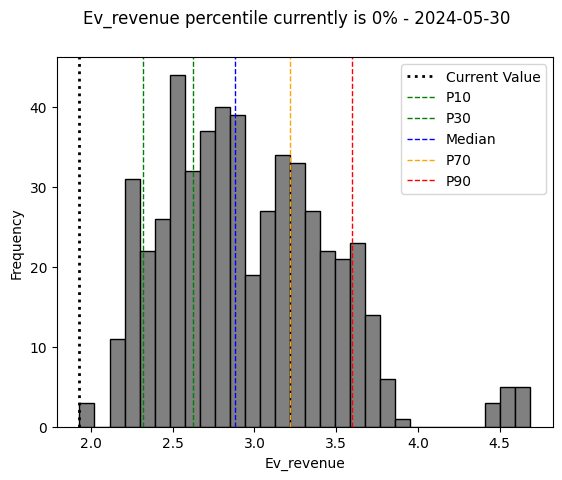

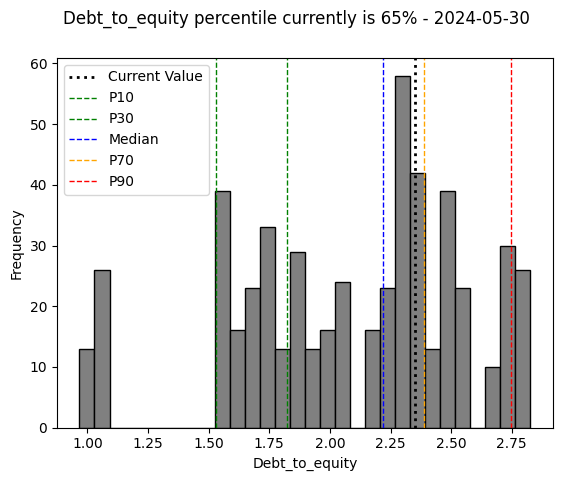

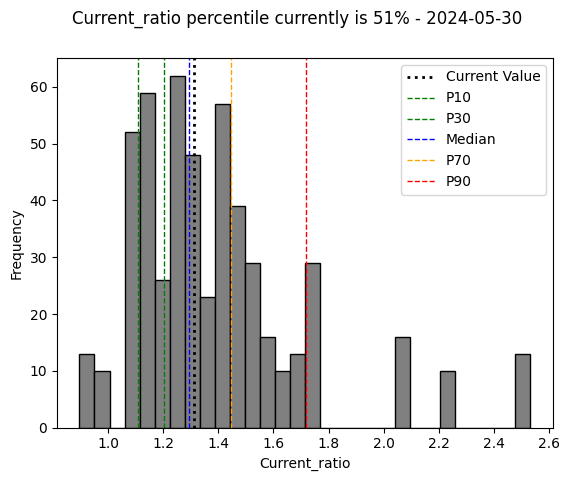

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.992843,0.146238,0.348142,0.453196,-0.017373,-0.493764,0.474557
roe,0.992843,1.000000,0.163900,0.358637,0.400888,-0.048509,-0.429030,0.395254
pe_ratio,0.146238,0.163900,1.000000,-0.022538,-0.016669,0.040308,0.031900,-0.050054
pb_ratio,0.348142,0.358637,-0.022538,1.000000,0.636546,-0.024009,0.005255,0.253676
ps_ratio,0.453196,0.400888,-0.016669,0.636546,1.000000,0.560375,-0.465579,0.643478
ev_revenue,-0.017373,-0.048509,0.040308,-0.024009,0.560375,1.000000,-0.003449,0.049416
debt_to_equity,-0.493764,-0.429030,0.031900,0.005255,-0.465579,-0.003449,1.000000,-0.825783
current_ratio,0.474557,0.395254,-0.050054,0.253676,0.643478,0.049416,-0.825783,1.000000


0 timestemos have been found!


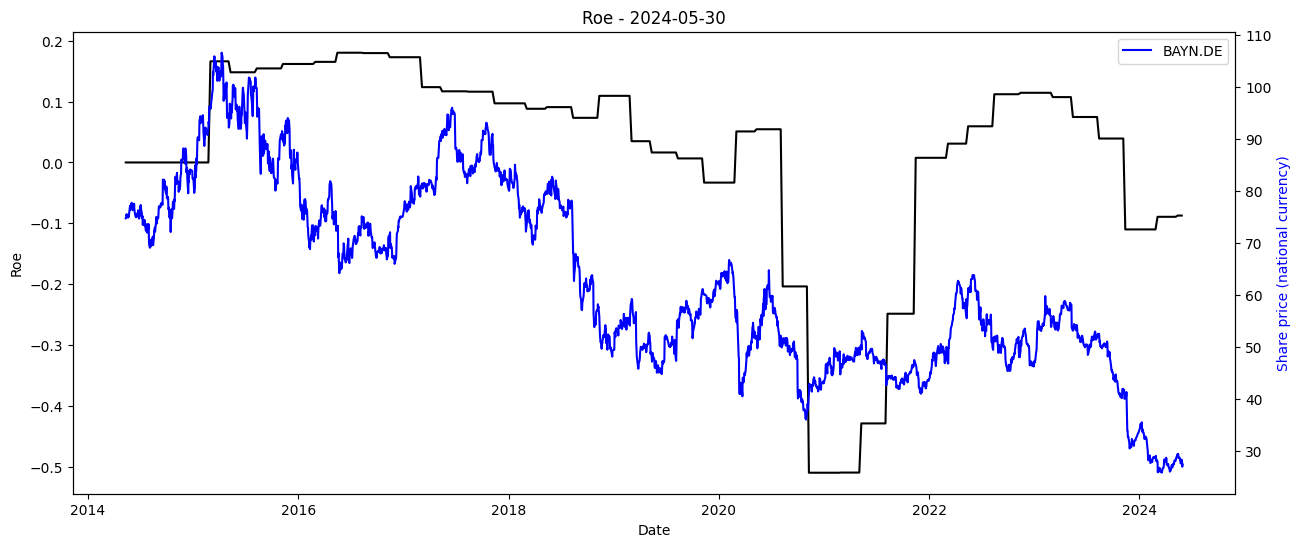

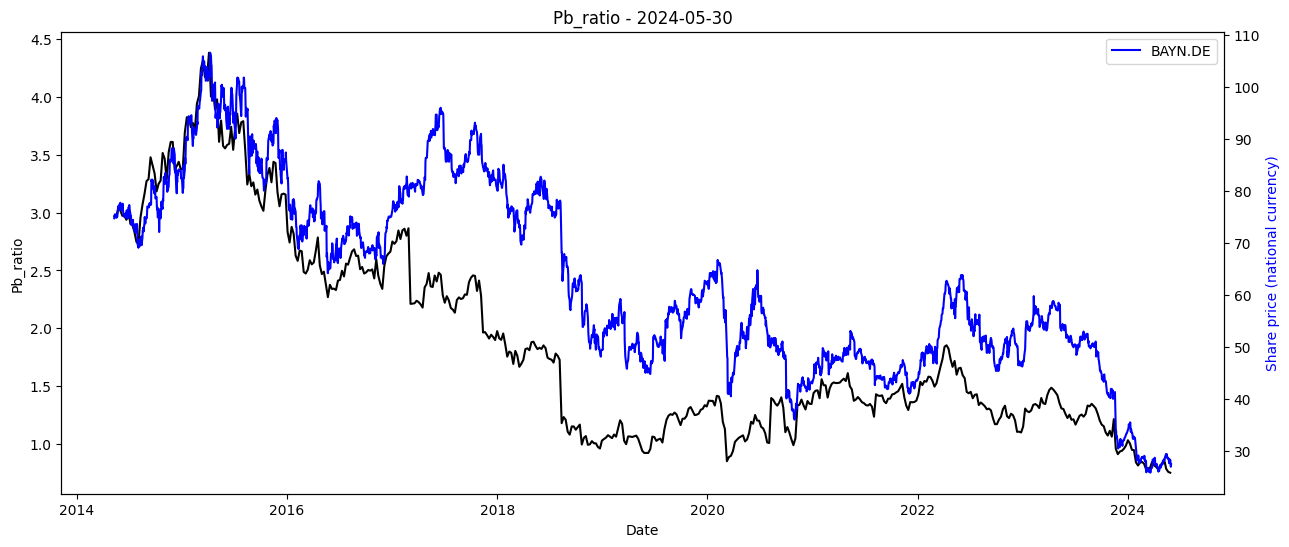

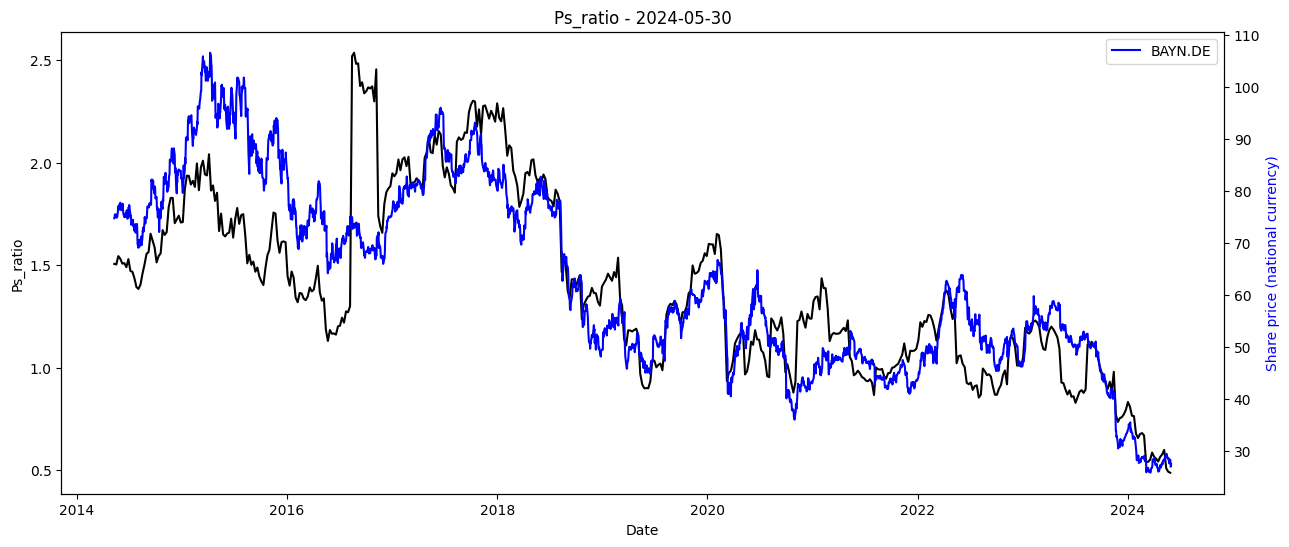

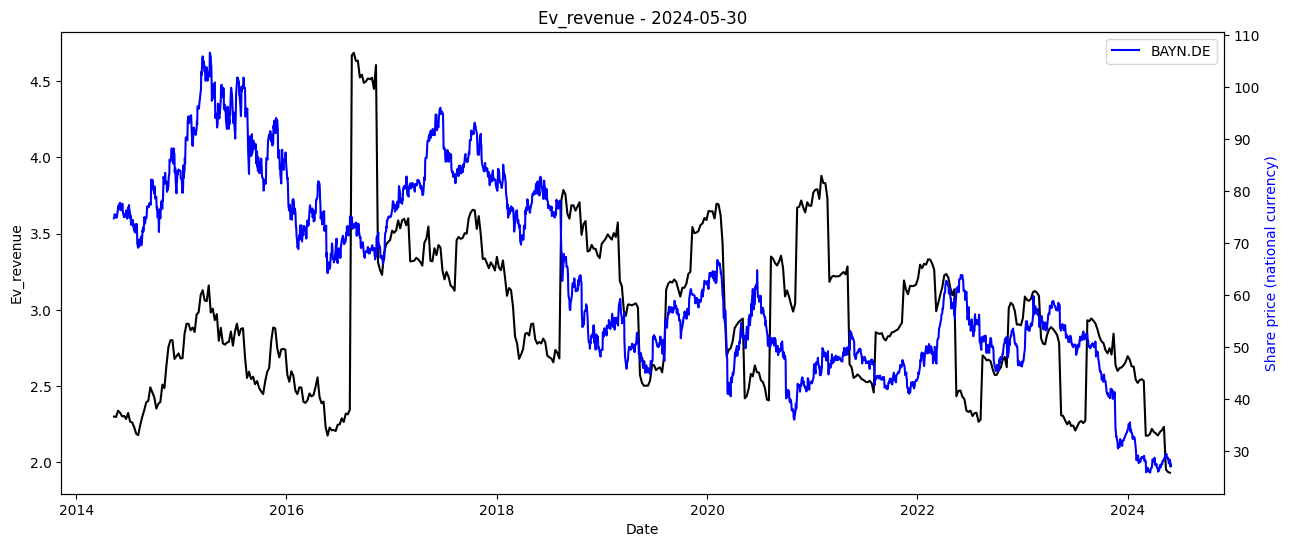

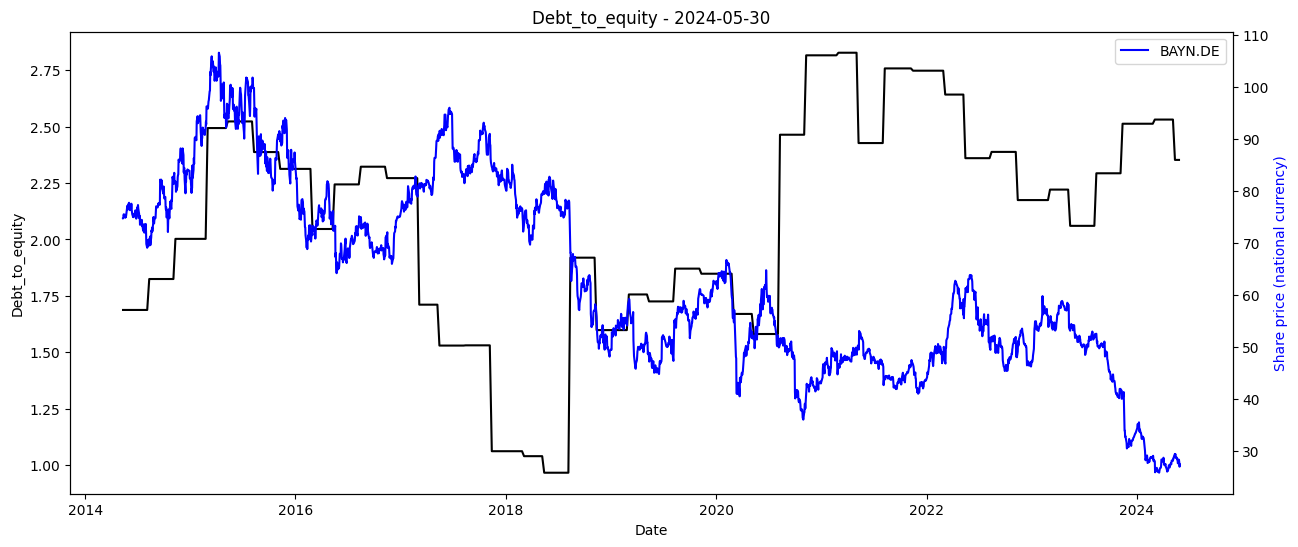

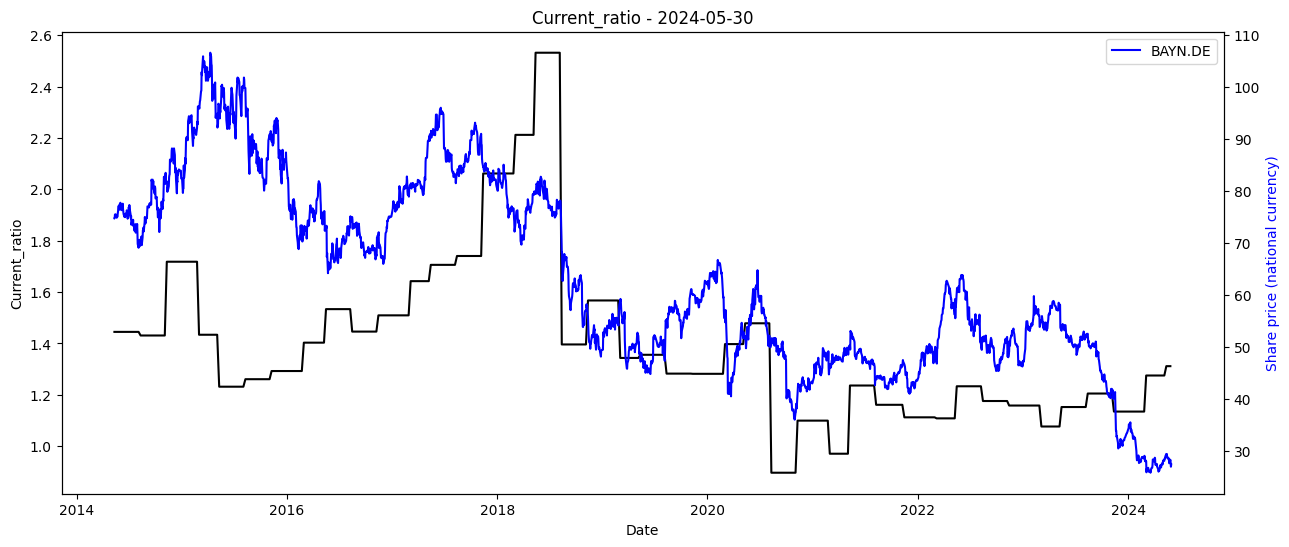

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )